### Cargar Datos e importar librerias

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import math
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Cargar los datos
file_path = "trafico_asturies_mes.csv"
df = pd.read_csv(file_path)
df_dia = pd.read_csv("trafico_asturies.csv")

### Mostrar datos

In [3]:
df.head()

timestamp                   street   latitude  longitude  \
0  2025-01-01 00:00:00  Fuso de la Reina- Tuñón  43.492229  -5.660493   
1  2025-01-01 00:00:00      Plaza de Olof Palme  39.472714  -0.349138   
2  2025-01-01 00:00:00          Camin del Peñón  43.458737  -5.756044   
3  2025-01-01 00:00:00           Caleya del Río  43.456455  -5.607828   
4  2025-01-01 00:00:00         Cerro la Muralla  20.378618 -99.958288   

   currentSpeed  freeFlowSpeed  currentTravelTime  freeFlowTravelTime  \
0            54             57                 18                  17   
1            99             99                 10                  10   
2            90             94                 11                  10   
3            57             61                 17                  16   
4            39             42                 25                  23   

   confidence  roadClosure  
0        0.97        False  
1        0.83        False  
2        0.81        False  
3        0.97        False  
4        0.93        False

### Datos estadísticos e información

In [4]:
print(df.columns)
print(df.shape)
print(df.index)
print(df.info())
df.describe()

Index(['timestamp', 'street', 'latitude', 'longitude', 'currentSpeed',
       'freeFlowSpeed', 'currentTravelTime', 'freeFlowTravelTime',
       'confidence', 'roadClosure'],
      dtype='object')
(2884320, 10)
RangeIndex(start=0, stop=2884320, step=1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2884320 entries, 0 to 2884319
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   timestamp           object 
 1   street              object 
 2   latitude            float64
 3   longitude           float64
 4   currentSpeed        int64  
 5   freeFlowSpeed       int64  
 6   currentTravelTime   int64  
 7   freeFlowTravelTime  int64  
 8   confidence          float64
 9   roadClosure         bool   
dtypes: bool(1), float64(3), int64(4), object(2)
memory usage: 200.8+ MB
None


latitude     longitude  currentSpeed  freeFlowSpeed  \
count  2.884320e+06  2.884320e+06  2.884320e+06   2.884320e+06   
mean   3.944082e+01 -1.052382e+01  6.323744e+01   6.898634e+01   
std    1.495144e+01  1.962291e+01  2.323133e+01   2.040994e+01   
min   -5.482315e+01 -1.221166e+02  1.800000e+01   3.000000e+01   
25%    4.336340e+01 -5.758328e+00  4.400000e+01   5.100000e+01   
50%    4.350347e+01 -5.685010e+00  6.100000e+01   6.900000e+01   
75%    4.353547e+01 -5.649039e+00  8.200000e+01   8.700000e+01   
max    4.735101e+01  1.014373e+02  1.180000e+02   1.080000e+02   

       currentTravelTime  freeFlowTravelTime    confidence  
count       2.884320e+06        2.884320e+06  2.884320e+06  
mean        1.804773e+01        1.552607e+01  8.999846e-01  
std         8.261183e+00        5.435441e+00  5.788987e-02  
min         8.000000e+00        9.000000e+00  8.000000e-01  
25%         1.200000e+01        1.100000e+01  8.500000e-01  
50%         1.600000e+01        1.400000e+01  9.000000e-01  
75%         2.200000e+01        1.900000e+01  9.500000e-01  
max         5.500000e+01        3.300000e+01  1.000000e+00

In [5]:
df.describe(include='object')

timestamp                  street
count               2884320                 2884320
unique                  720                    4006
top     2025-01-30 07:00:00  Camín de Las Orquídeas
freq                   4006                     720

### Ver si hay filas duplicadas

In [6]:
# Contar el número de filas duplicadas
num_duplicates = df.duplicated().sum()
print(f"Número de filas duplicadas: {num_duplicates}")

Número de filas duplicadas: 0


In [7]:
# Encontrar filas duplicadas
filas_duplicadas = df[df.duplicated()]

### Ver si hay datos faltantes

In [8]:
def valores_faltantes(data):
  total = data.isnull().sum()
  porcentaje = (data.isnull().sum()/data.isnull().count()*100)
  tt = pd.concat([total, porcentaje], axis=1, keys=['Total', 'Porcentaje'])
  types = []
  for col in data.columns:
    dtype = str(data[col].dtype)
    types.append(dtype)
  tt['Tipos'] = types
  return np.transpose(tt)

valores_faltantes(df)

timestamp  street latitude longitude currentSpeed freeFlowSpeed  \
Total              0       0        0         0            0             0   
Porcentaje       0.0     0.0      0.0       0.0          0.0           0.0   
Tipos         object  object  float64   float64        int64         int64   

           currentTravelTime freeFlowTravelTime confidence roadClosure  
Total                      0                  0          0           0  
Porcentaje               0.0                0.0        0.0         0.0  
Tipos                  int64              int64    float64        bool

In [9]:
df['street'].unique()

array(['Fuso de la Reina- Tuñón', 'Plaza de Olof Palme',
       'Camin del Peñón', ..., 'Avenida de Luis Braille',
       'Camín de Morán', 'Camín de Las Orquídeas'], dtype=object)

### Análisis Univariante

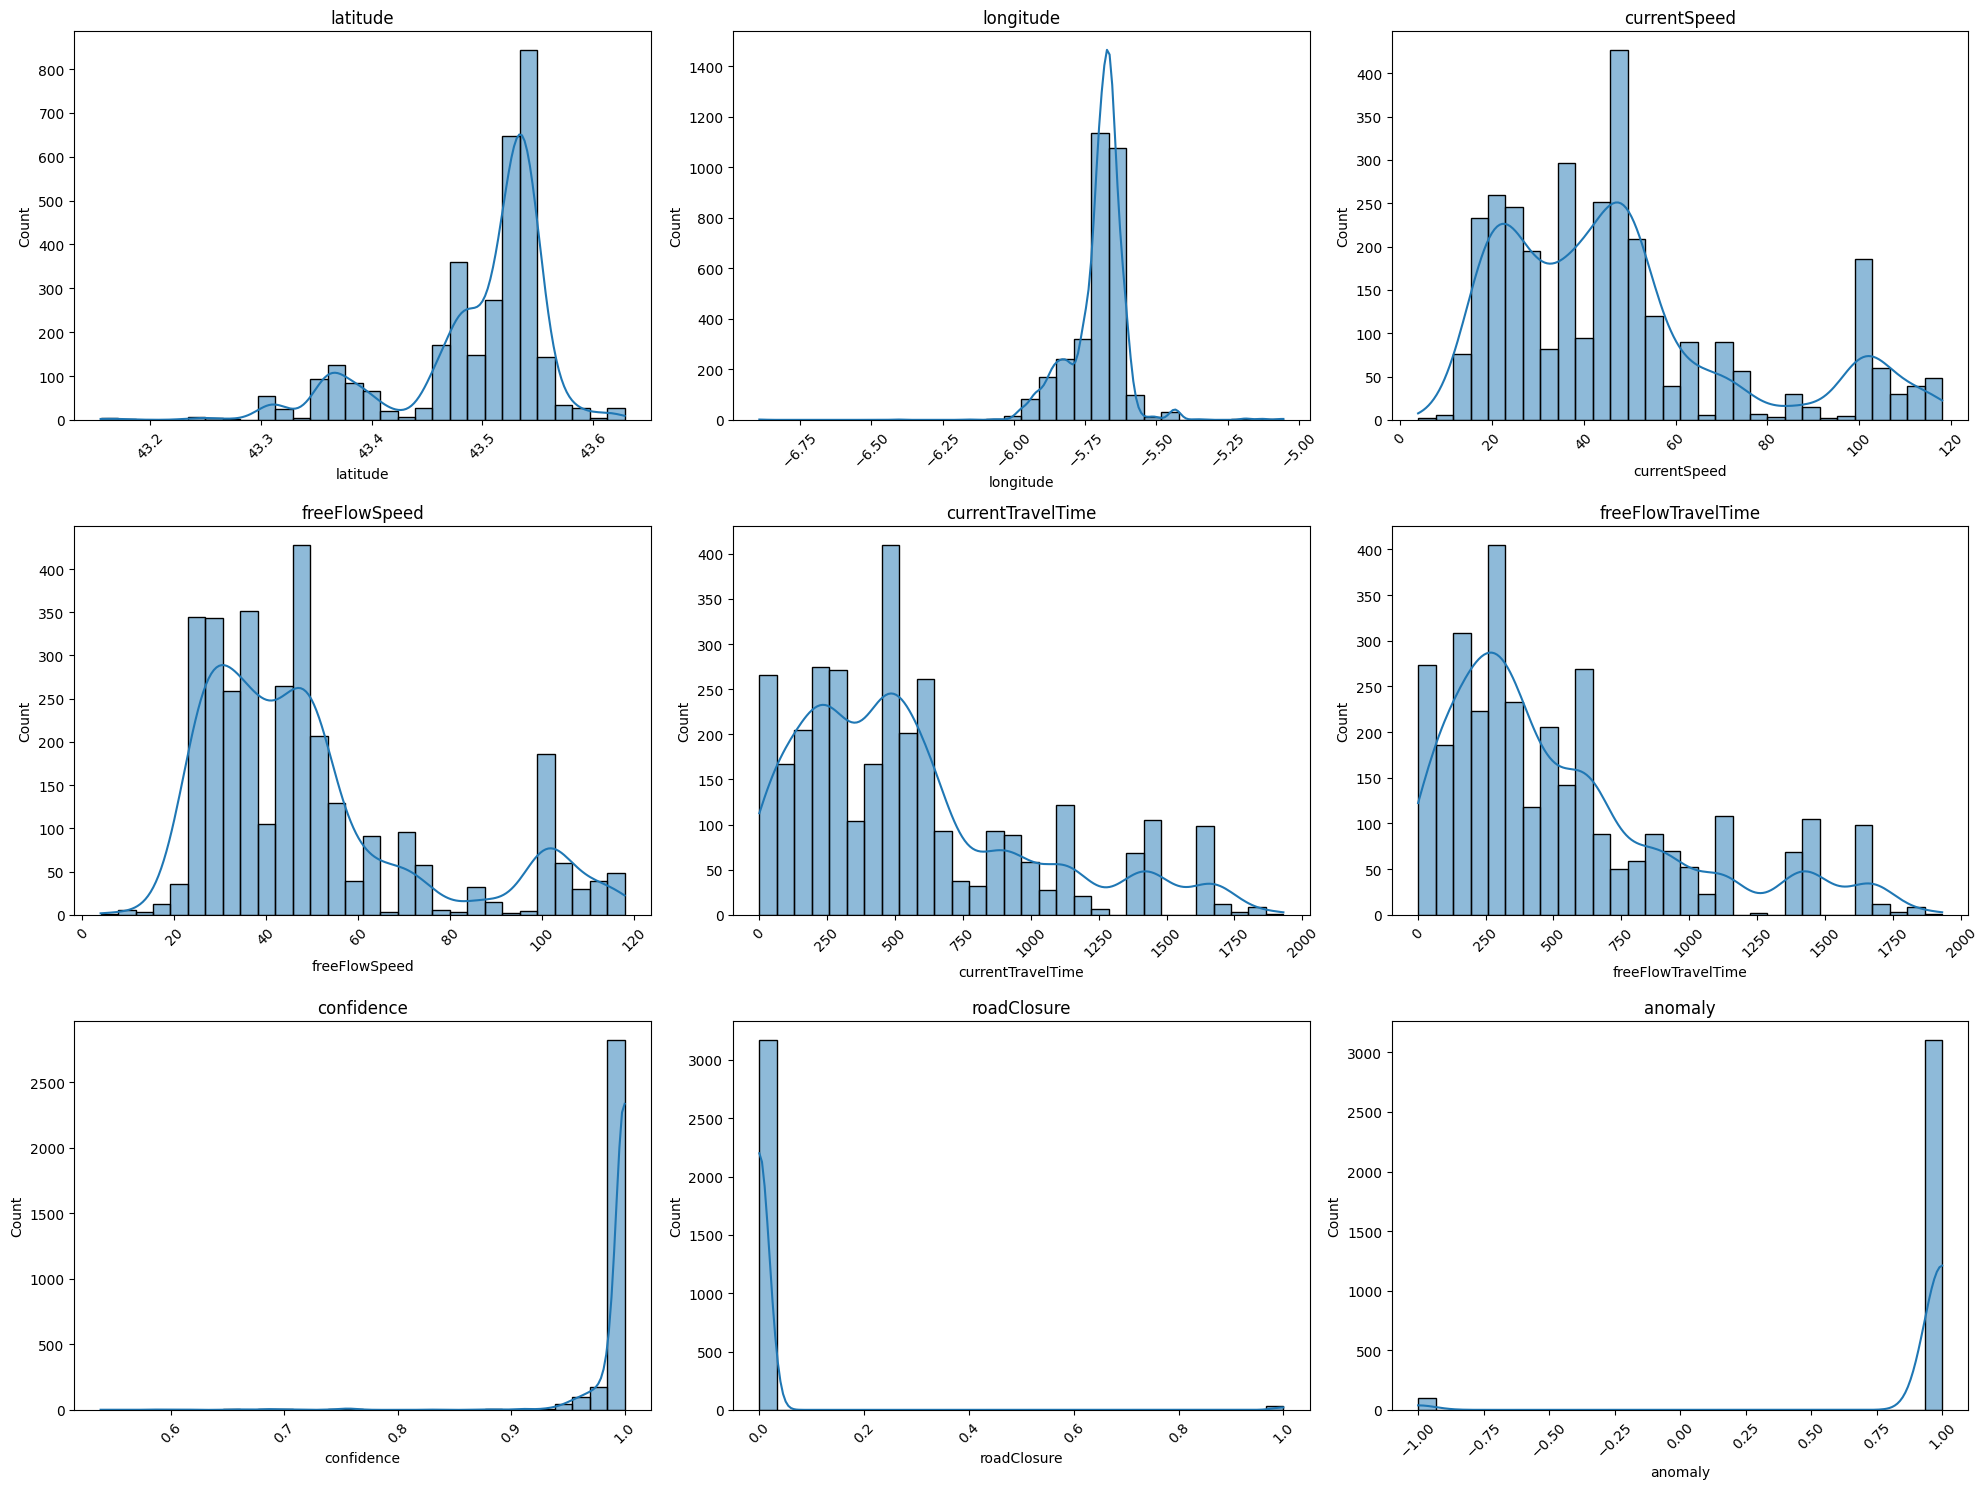

In [26]:
def analisis_univariante(data, cols=3, width=20, height=15):
    fig = plt.figure(figsize=(width, height))
    rows = math.ceil((data.shape[1] - 1) / cols)
    plot_index = 1

    for column in data.columns:
        if column == 'street':
            continue  # Saltar columna
        elif column == 'timestrap':
            continue

        ax = fig.add_subplot(rows, cols, plot_index)
        plot_index += 1
        ax.set_title(column)

        if data[column].dtype == 'object':
            top_categories = data[column].value_counts().index[:10]
            sns.countplot(data=data[data[column].isin(top_categories)],
                          y=column,
                          ax=ax,
                          palette='viridis',
                          hue=column,
                          legend=False)
            plt.xticks(rotation=45)
        else:
            sns.histplot(data[column], ax=ax, kde=True, bins=30)
            plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Llamar a la función con el DataFrame existente
analisis_univariante(df)

### Comparar Velocidad de Vía con Velocidad del tráfico en un día

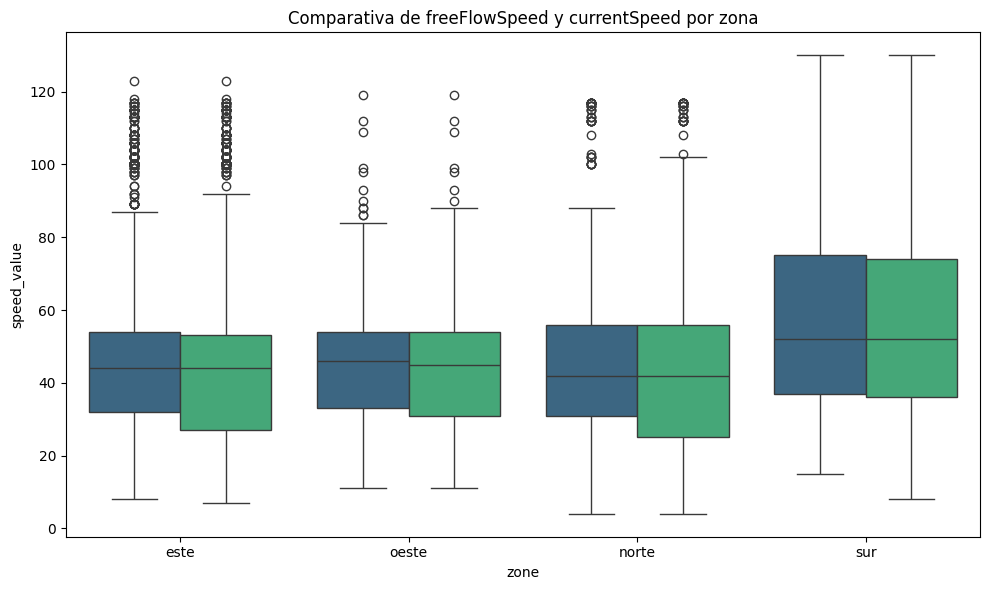

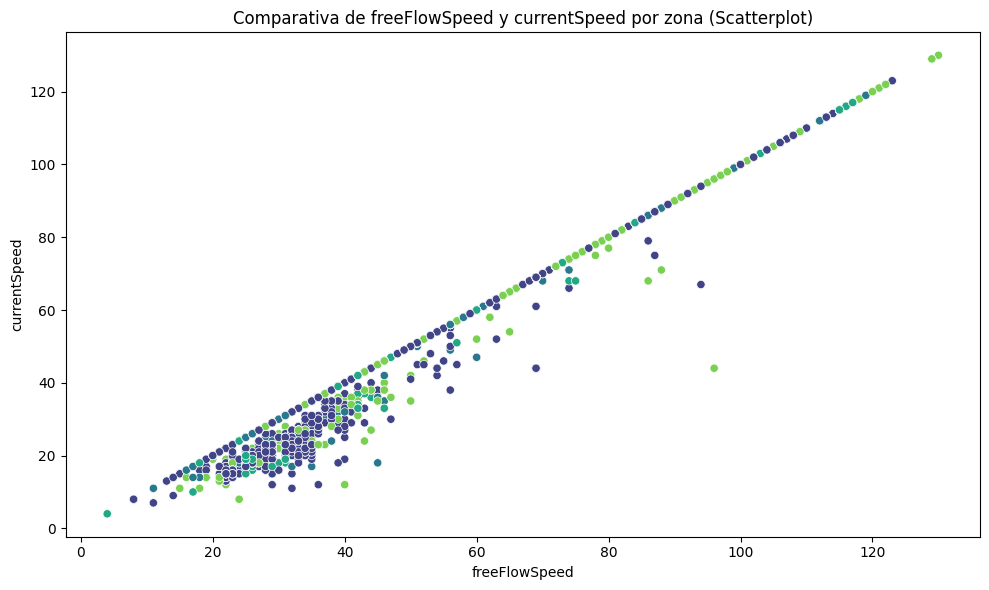

In [31]:
def get_zone(lat, lon, center_lat=43.36, center_lon=-5.87):
    lat_diff = lat - center_lat
    lon_diff = lon - center_lon
    # Asignamos la zona según la componente con mayor diferencia
    if abs(lat_diff) > abs(lon_diff):
        return "norte" if lat_diff > 0 else "sur"
    else:
        return "este" if lon_diff > 0 else "oeste"

# Actualizar la columna 'zone' usando el DataFrame ya cargado con datos de Asturias
df_dia["zone"] = df_dia.apply(lambda row: get_zone(row["latitude"], row["longitude"]), axis=1)

# Unir (melt) las columnas de velocidad para compararlas en un mismo gráfico
df_melted = df_dia.melt(
    id_vars=["zone"],
    value_vars=["freeFlowSpeed", "currentSpeed"],
    var_name="speed_type",
    value_name="speed_value"
)

# Diagrama de cajas
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, x="zone", y="speed_value", hue="speed_type", palette="viridis", dodge=True)
plt.title("Comparativa de freeFlowSpeed y currentSpeed por zona")
plt.legend([],[], frameon=False)  # Disable legend
plt.tight_layout()
plt.show()

# Scatterplot comparando freeFlowSpeed y currentSpeed
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_dia, x="freeFlowSpeed", y="currentSpeed", hue="zone", palette="viridis", legend=False)
plt.title("Comparativa de freeFlowSpeed y currentSpeed por zona (Scatterplot)")
plt.tight_layout()
plt.show()


### Comparar tiempo de viaje normal y actual en un día

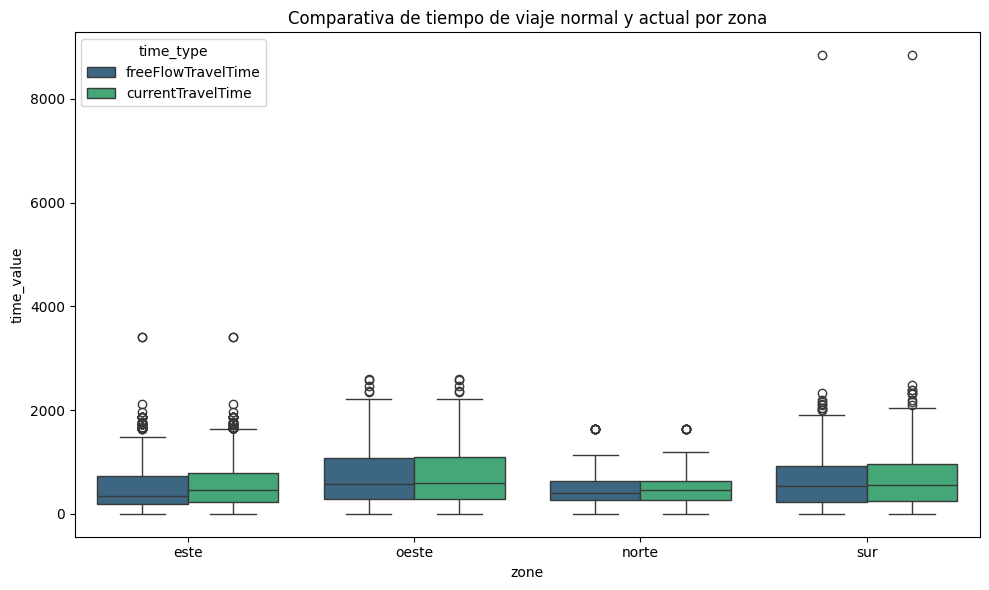

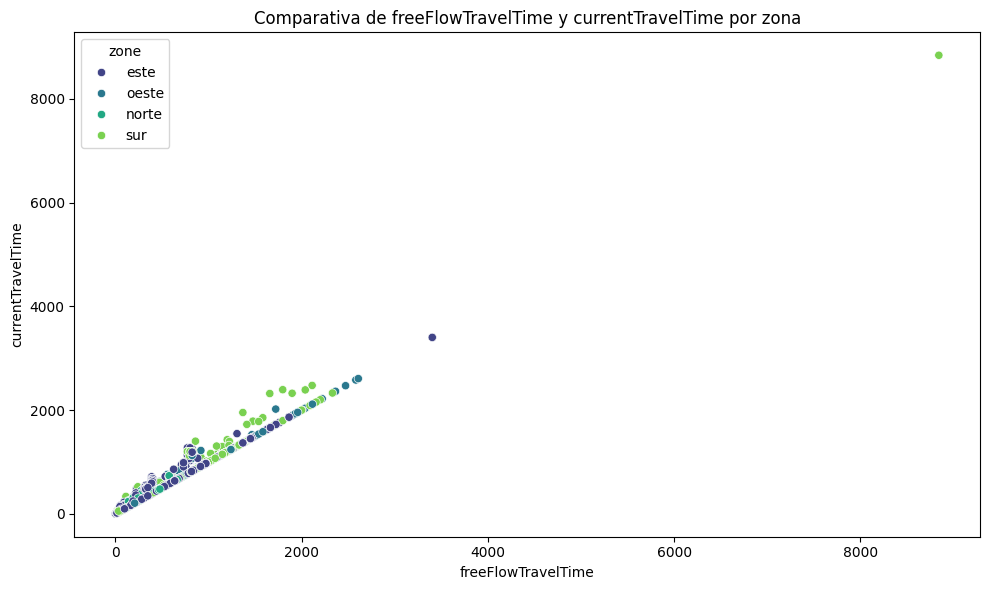

In [32]:
def get_zone(lat, lon, center_lat=43.36, center_lon=-5.87):
    lat_diff = lat - center_lat
    lon_diff = lon - center_lon
    # Asignamos la zona según la componente con mayor diferencia
    if abs(lat_diff) > abs(lon_diff):
        return "norte" if lat_diff > 0 else "sur"
    else:
        return "este" if lon_diff > 0 else "oeste"

# Crear la columna 'zone'
df_dia["zone"] = df_dia.apply(lambda row: get_zone(row["latitude"], row["longitude"]), axis=1)

# Unir (melt) las columnas de tiempo para compararlas en un mismo gráfico
df_melted = df_dia.melt(id_vars=["zone"], 
                    value_vars=["freeFlowTravelTime", "currentTravelTime"], 
                    var_name="time_type", 
                    value_name="time_value")

# Graficar diagrama de cajas
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, x="zone", y="time_value", hue="time_type", palette="viridis")
plt.title("Comparativa de tiempo de viaje normal y actual por zona")
plt.tight_layout()
plt.show()

# Scatterplot comparando freeFlowSpeed y currentSpeed, coloreado por zona
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_dia, x="freeFlowTravelTime", y="currentTravelTime", hue="zone", palette="viridis")
plt.title("Comparativa de freeFlowTravelTime y currentTravelTime por zona")
plt.tight_layout()
plt.show()

### Comparar Velocidad y tiempo en un día

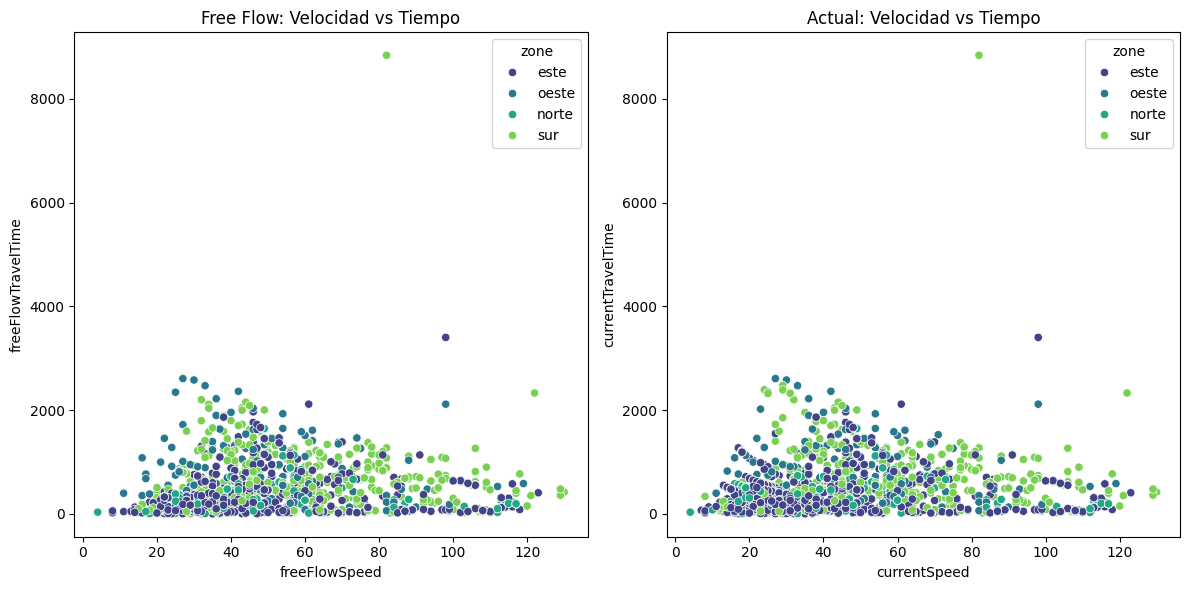

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_zone(lat, lon, center_lat=43.36, center_lon=-5.87):
    lat_diff = lat - center_lat
    lon_diff = lon - center_lon
    if abs(lat_diff) > abs(lon_diff):
        return "norte" if lat_diff > 0 else "sur"
    else:
        return "este" if lon_diff > 0 else "oeste"

df_dia["zone"] = df_dia.apply(lambda row: get_zone(row["latitude"], row["longitude"]), axis=1)

plt.figure(figsize=(12, 6))

# Subplot 1: Free flow
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_dia, x="freeFlowSpeed", y="freeFlowTravelTime", hue="zone", palette="viridis")
plt.title("Free Flow: Velocidad vs Tiempo")

# Subplot 2: Actual
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_dia, x="currentSpeed", y="currentTravelTime", hue="zone", palette="viridis")
plt.title("Actual: Velocidad vs Tiempo")

plt.tight_layout()
plt.show()

### Evolución del tráfico en un día

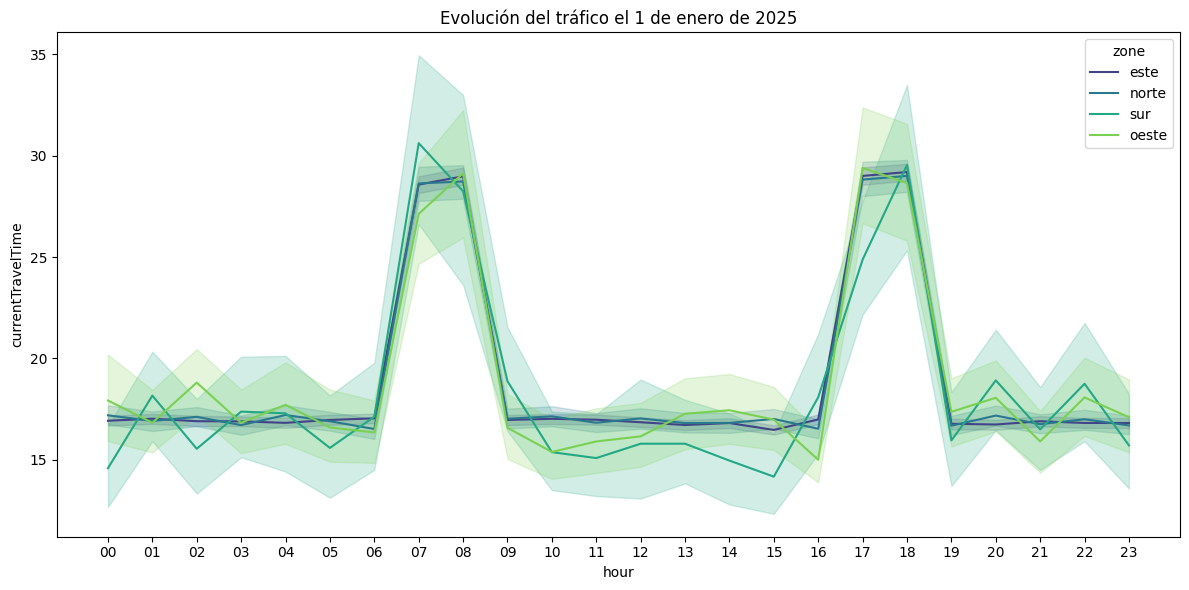

In [47]:
# Filtrar los datos para el 1 de enero de 2025
df_dia_1_enero = df[df["timestamp"].str.contains("2025-01-01")].copy()

# Extraer solo la hora de los registros
df_dia_1_enero.loc[:, "hour"] = df_dia_1_enero["timestamp"].str[11:13]

# Graficar la evolución del tráfico el 1 de enero de 2025
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_dia_1_enero, x="hour", y="currentTravelTime", hue="zone", palette="viridis")
plt.title("Evolución del tráfico el 1 de enero de 2025")
plt.tight_layout()
plt.show()


### Mapa de tráfico en Asturias en un día

In [ ]:
import pandas as pd
import folium

# Filtra solo las coordenadas dentro de un rango razonable para Asturias
df_dia_filtro = df_dia[
    (df_dia["latitude"].between(43.1, 43.7)) &
    (df_dia["longitude"].between(-7.0, -5.0))
]

# Función para asignar color según nivel de tráfico (velocidad actual / velocidad libre)
def get_color_ratio(speed, free_speed):
    ratio = speed / free_speed if free_speed else 0
    if ratio < 0.4:
        return "red"
    elif ratio < 0.7:
        return "orange"
    elif ratio < 1:
        return "red"
    else:
        return "green"

# Crea el mapa centrado aproximadamente en Asturias
mapa = folium.Map(location=[43.36, -5.87], zoom_start=8)

# Agrega marcadores con colores según tráfico y marcadores especiales para calles cerradas
for _, row in df_dia_filtro.iterrows():
    color = "black" if row["roadClosure"] else get_color_ratio(row["currentSpeed"], row["freeFlowSpeed"])
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=6,
        color=color,
        fill=True,
        fill_color=color,
        popup=row["street"]
    ).add_to(mapa)

mapa.save("mapa_trafico_asturies.html")
mapa

### Aplicar PCA, escalar datos y eliminar outliers

In [48]:
# Seleccionar columnas relevantes para clustering
X = df_dia[['latitude', 'longitude', 'currentSpeed', 'freeFlowSpeed', 'currentTravelTime', 'freeFlowTravelTime']]

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar Isolation Forest para eliminar outliers antes del clustering
iso_forest = IsolationForest(contamination=0.03, random_state=42)
anomalies = iso_forest.fit_predict(X_scaled)
df_dia['anomaly'] = anomalies
X_filtered = X_scaled[df_dia['anomaly'] == 1]

# Aplicar PCA para reducir dimensiones antes de clustering
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_filtered)
df_filtered = df_dia[df_dia['anomaly'] == 1].copy()
df_filtered[['PCA1', 'PCA2']] = X_pca

### Agrupación con clusters (KMEANS)

Mejor n_clusters=3, Silhouette=0.5567
Silhouette Score (K-Means): 0.56
              latitude  longitude  currentSpeed  freeFlowSpeed  \
cluster_opt                                                      
0            38.151960 -12.310971     48.320498      48.889015   
1            42.495184  -6.537781     91.485981      91.683578   
2            41.876655  -7.817671     33.190413      36.341323   

             currentTravelTime  freeFlowTravelTime  confidence  anomaly  \
cluster_opt                                                               
0                  1197.241223         1174.613817    0.997432      1.0   
1                   389.662216          388.802403    0.999673      1.0   
2                   348.022636          307.531735    0.986828      1.0   

                 PCA1      PCA2  cluster_opt  
cluster_opt                                   
0            0.531165  1.907323          0.0  
1            2.199098 -1.101562          1.0  
2           -0.939256 -0.381312   

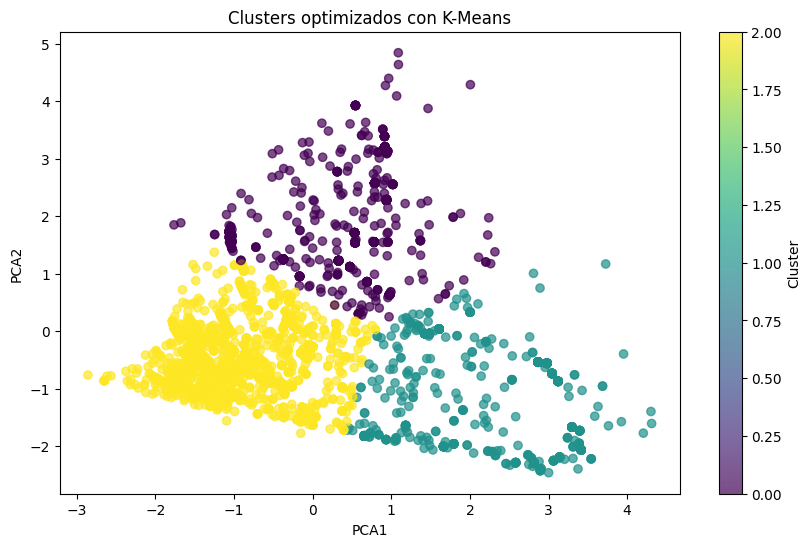

In [49]:
scores = []
for n_c in range(2, 11):
    kmeans_temp = KMeans(n_clusters=n_c, random_state=42, n_init=20)
    labels_temp = kmeans_temp.fit_predict(X_pca)
    score_temp = silhouette_score(X_pca, labels_temp)
    scores.append((n_c, score_temp))

best_n, best_score = max(scores, key=lambda x: x[1])
print(f"Mejor n_clusters={best_n}, Silhouette={best_score:.4f}")

kmeans = KMeans(n_clusters=best_n, random_state=42, n_init=20)
df_filtered['cluster_opt'] = kmeans.fit_predict(X_pca)

# Evaluar K-Means con Silhouette Score
silhouette_kmeans = silhouette_score(X_pca, df_filtered['cluster_opt'])
print(f"Silhouette Score (K-Means): {silhouette_kmeans:.2f}")

# Ver lo que representan los clusters
numeric_cols = df_filtered.select_dtypes(include=['number']).columns
print(df_filtered.groupby("cluster_opt")[numeric_cols].mean())

# Visualizar los clusters en PCA
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_filtered['PCA1'], df_filtered['PCA2'], c=df_filtered['cluster_opt'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("Clusters optimizados con K-Means")
plt.show()

In [50]:
# muestra las calles agrupadas
df_filtered.groupby("cluster_opt")["street"].unique()

cluster_opt
0    [Caleya del Río, Camín de Riusecu, Entrada apa...
1    [Camin del Peñón, Travesía de La Vega, Carrete...
2    [Fuso de la Reina- Tuñón, Plaza de Olof Palme,...
Name: street, dtype: object

### Agrupación con clusters (DBSCAN)

Mejores parámetros DBSCAN: eps=0.4, min_samples=10 (Silhouette=0.37)
Silhouette Score (DBSCAN): 0.37
                 latitude  longitude  currentSpeed  freeFlowSpeed  \
dbscan_cluster                                                      
-1              38.490731 -14.207163     74.541667      74.666667   
 0              41.165864  -8.557272     47.702409      49.708625   

                currentTravelTime  freeFlowTravelTime  confidence  anomaly  \
dbscan_cluster                                                               
-1                    1299.000000         1292.916667    0.980556      1.0   
 0                     544.403004          515.471639    0.991784      1.0   

                    PCA1      PCA2  cluster_opt  dbscan_cluster  
dbscan_cluster                                                   
-1              2.034371  1.825528     0.291667            -1.0  
 0             -0.012646 -0.011347     1.359233             0.0  


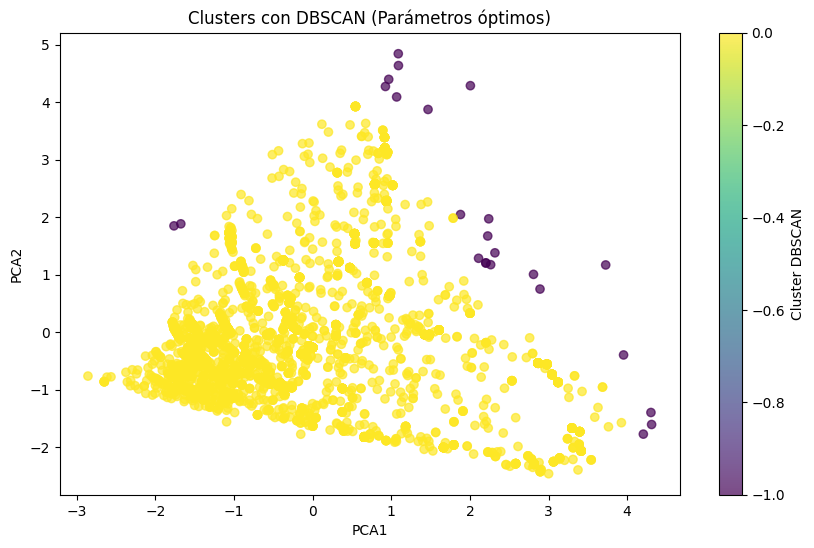

In [51]:
# Probar varios valores de eps y min_samples para mejorar la silueta con DBSCAN
best_score = -1
best_params = (0.4, 10)

for eps_test in [0.2, 0.25, 0.3, 0.35, 0.4]:
    for min_samp_test in [5, 10, 15, 20]:
        dbscan_temp = DBSCAN(eps=eps_test, min_samples=min_samp_test)
        labels_temp = dbscan_temp.fit_predict(X_pca)
        # Solo evaluamos la silueta si hay más de un cluster
        if len(set(labels_temp)) > 1:
            score_temp = silhouette_score(X_pca, labels_temp)
            if score_temp > best_score:
                best_score = score_temp
                best_params = (eps_test, min_samp_test)

print(f"Mejores parámetros DBSCAN: eps={best_params[0]}, min_samples={best_params[1]} (Silhouette={best_score:.2f})")

dbscan = DBSCAN(eps=best_params[0], min_samples=best_params[1])
df_filtered['dbscan_cluster'] = dbscan.fit_predict(X_pca)
silhouette_dbscan = silhouette_score(X_pca, df_filtered['dbscan_cluster'])
print(f"Silhouette Score (DBSCAN): {silhouette_dbscan:.2f}")

numeric_cols = df_filtered.select_dtypes(include=['number']).columns
# Ver promedios por cluster (usando la columna 'cluster' previa como referencia si se necesita)
print(df_filtered.groupby("dbscan_cluster")[numeric_cols].mean())

# Visualizar Clustering DBSCAN
plt.figure(figsize=(10,6))
plt.scatter(df_filtered['PCA1'], df_filtered['PCA2'], c=df_filtered['dbscan_cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(label="Cluster DBSCAN")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("Clusters con DBSCAN (Parámetros óptimos)")
plt.show()

In [52]:
# muestra las calles agrupadas
df_filtered.groupby("dbscan_cluster")["street"].unique()

dbscan_cluster
-1    [Calle Joaquín Costa, Paseo de Poniente - Fome...
 0    [Fuso de la Reina- Tuñón, Plaza de Olof Palme,...
Name: street, dtype: object

### Detectar anomalías en tráfico

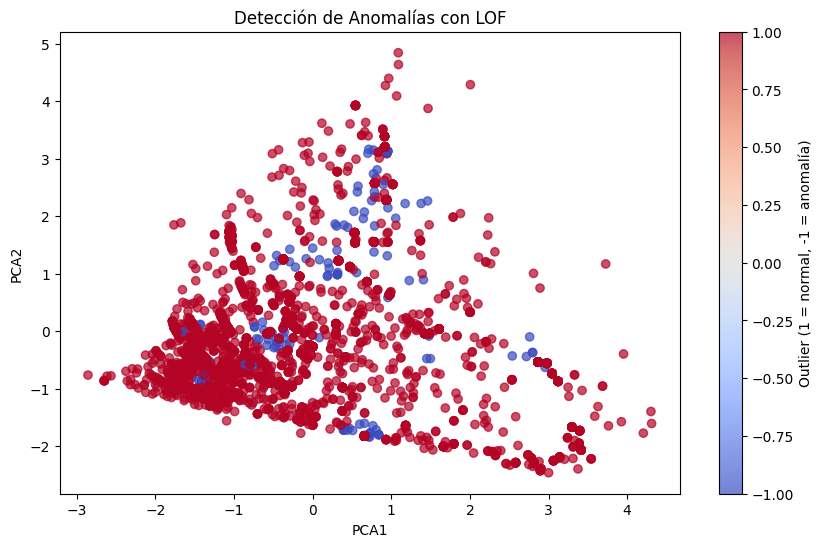

In [53]:
# Aplicar Local Outlier Factor para detección de anomalías
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
df_filtered['lof_outlier'] = lof.fit_predict(X_pca)

# Visualizar anomalías detectadas
plt.figure(figsize=(10,6))
plt.scatter(df_filtered['PCA1'], df_filtered['PCA2'], c=df_filtered['lof_outlier'], cmap='coolwarm', alpha=0.7)
plt.colorbar(label="Outlier (1 = normal, -1 = anomalía)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("Detección de Anomalías con LOF")
plt.show()

In [54]:
# mostrar calles con anomalias
df_filtered[df_filtered['lof_outlier'] == -1]['street']

62                             Calle Ribera
66                   Calle Alejandro Casona
73                   Camín de San Llorienzu
74                          Calle Almacenes
81                    Calle Tomás Zarracina
                       ...                 
3887                       Calle Los Corzos
3900                  Carbayera de Caldones
3970                         Calle La Salle
3990                   Calle Nelson Mandela
3997    Calle Obdulia Alvarez "La Busdonga"
Name: street, Length: 194, dtype: object

### Ver las anomalías en el mapa

Empty DataFrame
Columns: [latitude, longitude, currentSpeed, freeFlowSpeed, currentTravelTime]
Index: []


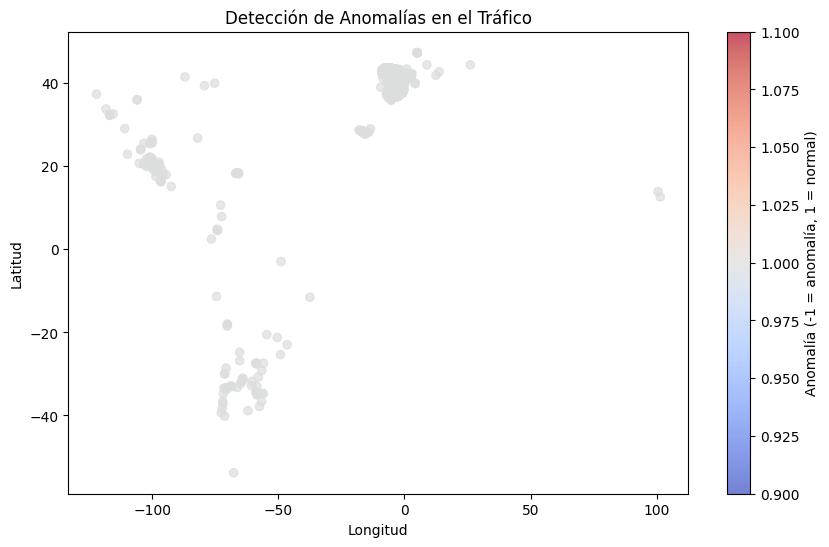

In [55]:
# Ver solo las anomalías detectadas (-1 significa anomalía)
anomalies = df_filtered[df_filtered['anomaly'] == -1]

# Mostrar algunas anomalías detectadas
print(anomalies[['latitude', 'longitude', 'currentSpeed', 'freeFlowSpeed', 'currentTravelTime']])

plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['longitude'], df_filtered['latitude'], c=df_filtered['anomaly'], cmap='coolwarm', alpha=0.7)
plt.colorbar(label="Anomalía (-1 = anomalía, 1 = normal)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Detección de Anomalías en el Tráfico")
plt.show()

### Agrupaciones de calles por velocidad

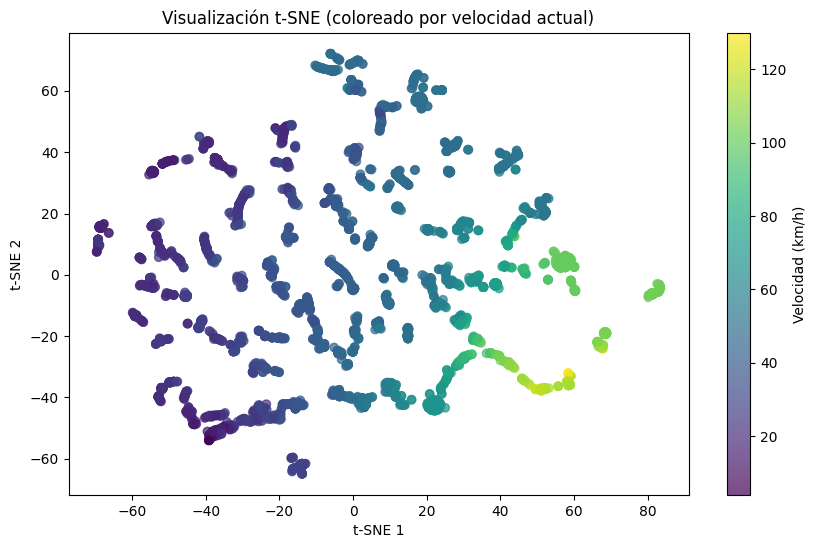

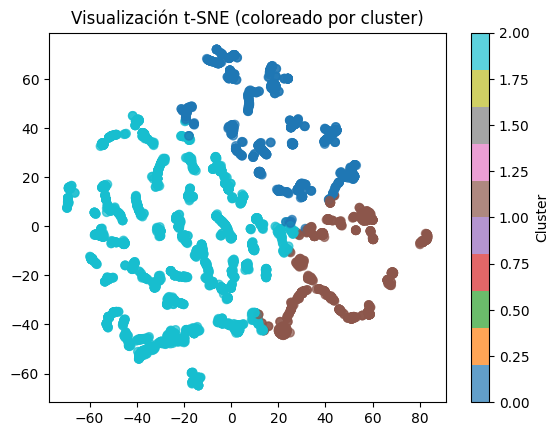

In [56]:
# Aplicar t-SNE para visualización en 2D
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

plt.figure(figsize=(10,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df_filtered['currentSpeed'], cmap='viridis', alpha=0.7)
plt.colorbar(label="Velocidad (km/h)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("Visualización t-SNE (coloreado por velocidad actual)")
plt.show()

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df_filtered['cluster_opt'], cmap='tab10', alpha=0.7)
plt.colorbar(label="Cluster")
plt.title("Visualización t-SNE (coloreado por cluster)")
plt.show()